# Importações e analise exploratória dos dados

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')


from utils import *

from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    make_scorer
)


from sklearn.decomposition import PCA

# Sentence Transformers
from sentence_transformers import SentenceTransformer

In [2]:
#configurações
df = pd.read_csv('../data/data_bq.csv')
random_state = 30
colors = Colors()

pca_explainability = 0.96
tuning = True


In [3]:
# Verificar estrutura básica dos dados
print_header("ESTRUTURA DO DATASET", colors.text_cyan)
colorfull_print(f"\nDimensões: {df.shape[0]} linhas x {df.shape[1]} colunas", colors.text_yellow)
for col in df.columns: colorfull_print(col, colors.text_green)

print_header("PRIMEIRAS LINHAS", colors.text_cyan)
df.head(10)

ESTRUTURA DO DATASET

Dimensões: 172758 linhas x 13 colunas
codigo_item
descricao_item
codigo_glosa
descricao_glosa
valor_glosa
justificativa
data_realizacao
valor_cobrado
quantidade_item
retorno_operadora
pago
convenio
prestador
PRIMEIRAS LINHAS


,codigo_item,descricao_item,codigo_glosa,descricao_glosa,valor_glosa,justificativa,data_realizacao,valor_cobrado,quantidade_item,retorno_operadora,pago,convenio,prestador
0,40316122,Antígeno Carcinoembriogênico (Cea),1601,REINCIDENCIA NO ATENDIMENTO,140.60,40316122- cobrança realizada conforme senha au...,2024-06-08 03:00:00 UTC,140.60,1,REINCIDENCIA NO ATENDIMENTO,True,UnimedCNU,BP
1,78241030,Conector Spiros Macho S/Trava,1707,NAO EXISTE INFORMACAO SOBRE A TABELA QUE SERA ...,212.22,"78241030- conforme aditivo vigente , simpro pu...",2024-06-04 03:00:00 UTC,212.22,1,NAO EXISTE INFORMACAO SOBRE A TABELA QUE SERA ...,True,UnimedCNU,BP
2,78241057,Tampa esteril CH-CAP 10,1707,NAO EXISTE INFORMACAO SOBRE A TABELA QUE SERA ...,56.13,Considerar 78241057- conforme aditivo vigente ...,2024-06-04 03:00:00 UTC,56.13,1,NAO EXISTE INFORMACAO SOBRE A TABELA QUE SERA ...,True,UnimedCNU,BP
3,78241065,Conector Clave Spike P/Bolsa,1707,NAO EXISTE INFORMACAO SOBRE A TABELA QUE SERA ...,213.91,"78241065- conforme aditivo vigente , simpro pu...",2024-06-04 03:00:00 UTC,213.91,1,NAO EXISTE INFORMACAO SOBRE A TABELA QUE SERA ...,False,UnimedCNU,BP
4,78241090,Conector Valvulado Microclave,1705,VALOR APRESENTADO A MAIOR,67.92,"78241090- conforme aditivo vigente , simpro pu...",2024-06-04 03:00:00 UTC,84.30,1,VALOR APRESENTADO A MAIOR,False,UnimedCNU,BP
5,79419682,Conector p/ Luer Macho e Fêmea,1707,NAO EXISTE INFORMACAO SOBRE A TABELA QUE SERA ...,18.75,"79419682- conforme aditivo vigente , simpro pu...",2024-06-04 03:00:00 UTC,18.75,1,NAO EXISTE INFORMACAO SOBRE A TABELA QUE SERA ...,False,UnimedCNU,BP
6,94301255,Produto Manipulado Forma Farmacêutica Líquida,1707,NAO EXISTE INFORMACAO SOBRE A TABELA QUE SERA ...,3.68,Considerar código 94301255 PRODUTO MANIPULADO ...,2024-06-04 03:00:00 UTC,3.68,1,NAO EXISTE INFORMACAO SOBRE A TABELA QUE SERA ...,False,UnimedCNU,BP
7,150376,Coletor Descartável Estéril 80mL,2010,COBRANCA DE MATERIAIS INCLUSOS NAS TAXAS,13.80,"150376-Conforme composição de taxa de sala, it...",2024-05-10 03:00:00 UTC,13.80,1,COBRANCA DE MATERIAIS INCLUSOS NAS TAXAS,True,UnimedCNU,BP
8,271542,Lamina P/Tricotomizador Cirúrgico Profissional 3M,2010,COBRANCA DE MATERIAIS INCLUSOS NAS TAXAS,141.80,"271542-Conforme composição de taxa de sala, it...",2024-05-10 03:00:00 UTC,141.80,1,COBRANCA DE MATERIAIS INCLUSOS NAS TAXAS,True,UnimedCNU,BP
9,238457,Carga 45mm para Grampeador Ets (Azul Tec.Espes...,1705,VALOR APRESENTADO A MAIOR,314.44,"00238457 -Liberado na senha 510951, guia op 22...",2024-05-10 03:00:00 UTC,964.44,1,VALOR APRESENTADO A MAIOR,False,UnimedCNU,BP


In [4]:
print_header("INFORMAÇÕES DO DADOS", colors.text_cyan)
df.info()

print_header("VALORES NULOS POR COLUNA", colors.text_red)
null_counts = df.isnull().sum()
null_percent = (df.isnull().sum() / len(df)) * 100
null_df = pd.DataFrame({
    'Nulos': null_counts,
    'Percentual': null_percent.round(2)
})
print(null_df[null_df['Nulos'] > 0])


print_header("VALORES DUPLICADOS", colors.text_red)
duplicated_rows = df.duplicated(keep=False)
df_dups = df[duplicated_rows]
print(f"Total de linhas duplicadas: {df_dups.shape[0]}")


INFORMAÇÕES DO DADOS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172758 entries, 0 to 172757
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   codigo_item        172758 non-null  int64  
 1   descricao_item     172758 non-null  object 
 2   codigo_glosa       171957 non-null  object 
 3   descricao_glosa    172758 non-null  object 
 4   valor_glosa        172758 non-null  float64
 5   justificativa      172758 non-null  object 
 6   data_realizacao    172758 non-null  object 
 7   valor_cobrado      172758 non-null  float64
 8   quantidade_item    172758 non-null  int64  
 9   retorno_operadora  171957 non-null  object 
 10  pago               172758 non-null  bool   
 11  convenio           172758 non-null  object 
 12  prestador          172758 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(8)
memory usage: 16.0+ MB
VALORES NULOS POR COLUNA
                   Nulos  Percentual

In [5]:
# Removendo linhas com valores nulos e duplicadas
df = df.dropna().drop_duplicates()
# remoção de colunas
df = df.drop(columns=['descricao_item', 'descricao_glosa', 'retorno_operadora', 'data_realizacao'])

''' As colunas de descricao possuem colunas correspondentes em código, o retorno da operadora só é fornecido após  o pagamento ou não da glosa
 e a data do pagamento não é relevante para a analise'''

print_header("DADOS APÓS REMOÇÃO DE VALORES NULOS, DUPLICADOS E COLUNAS NÃO UTILIZADAS", colors.text_cyan)
colorfull_print(f"Dimensões após limpeza: {df.shape[0]} linhas x {df.shape[1]} colunas", colors.text_yellow)

DADOS APÓS REMOÇÃO DE VALORES NULOS, DUPLICADOS E COLUNAS NÃO UTILIZADAS
Dimensões após limpeza: 112193 linhas x 9 colunas


In [6]:
# linhas com target conflitante
cols_except_target = [col for col in df.columns if col != 'pago']
duplicated_cases = df.duplicated(subset=cols_except_target, keep=False)

grouped = df[duplicated_cases].groupby(cols_except_target)['pago'].nunique().reset_index()
conflicting_cases = grouped[grouped['pago'] > 1]

print_header("CASOS CONFLITANTES ENCONTRADOS", colors.text_red)
colorfull_print(f"Foram encontrados {len(conflicting_cases)} casos em que todos os parâmetros são iguais, com target diferente.", colors.text_yellow)

CASOS CONFLITANTES ENCONTRADOS
Foram encontrados 4787 casos em que todos os parâmetros são iguais, com target diferente.


In [7]:
# Remover linhas conflitantes do DataFrame principal
df = df[~df.index.isin(conflicting_cases.index)]
print_header("DADOS APÓS REMOÇÃO DE LINHAS CONFLITANTES", colors.text_cyan)
colorfull_print(f"Dimensões após remoção: {df.shape[0]} linhas x {df.shape[1]} colunas", colors.text_yellow)

DADOS APÓS REMOÇÃO DE LINHAS CONFLITANTES
Dimensões após remoção: 109967 linhas x 9 colunas


VARIÁVEL ALVO: pago

Distribuição:
pago
False    67572
True     42395
Name: count, dtype: int64

Proporção:
pago
False    0.6145
True     0.3855
Name: proportion, dtype: float64


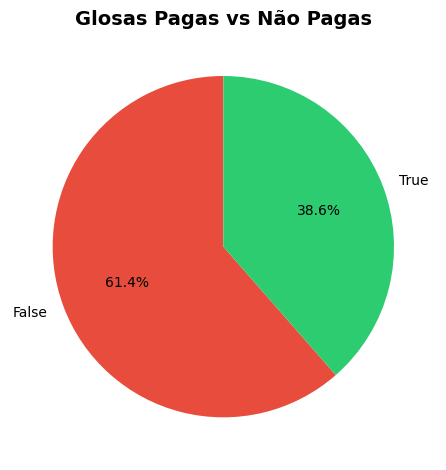

In [8]:
# Análise da variável alvo (pago)
print_header("VARIÁVEL ALVO: pago", colors.text_cyan)

print("\nDistribuição:")
colorfull_print(df['pago'].value_counts(), colors.text_yellow)
line(color=colors.text_cyan)
print("\nProporção:")
colorfull_print(df['pago'].value_counts(normalize=True).round(4), colors.text_yellow)
line(color=colors.text_cyan)



# Gráfico de pizza
df['pago'].value_counts().plot(kind='pie', autopct='%1.1f%%', 
            colors=[colors.red, colors.green], startangle=90)
plt.title('Glosas Pagas vs Não Pagas', fontsize=14, fontweight='bold')
plt.ylabel('')

plt.tight_layout()
plt.show()


Classe majoritária (False): 67572
Classe minoritária (True): 42395
BASE BALANCEADA
Distribuição do target após balanceamento:
pago
True     42395
False    42395
Name: count, dtype: int64

Verificando valores NaN por coluna:
codigo_item        0
codigo_glosa       0
valor_glosa        0
justificativa      0
valor_cobrado      0
quantidade_item    0
pago               0
convenio           0
prestador          0
dtype: int64


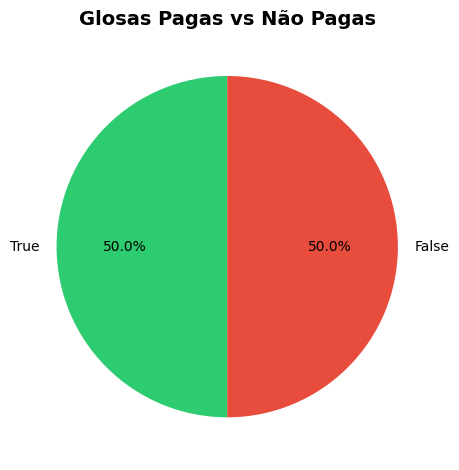

In [9]:
'''
    Balanceamento da base de dados
'''

# Separar as classes
df_majority = df[df['pago'] == False]
df_minority = df[df['pago'] == True]

colorfull_print(f"Classe majoritária (False): {len(df_majority)}", colors.text_red)
colorfull_print(f"Classe minoritária (True): {len(df_minority)}", colors.text_green)

# undersamble
df_majority_sampled = df_majority.sample(n=len(df_minority), random_state=random_state)

# Concatenando
df_balanced = pd.concat([df_majority_sampled, df_minority], ignore_index=True)

df_balanced = df_balanced.sample(frac=1, random_state=random_state).reset_index(drop=True)


print_header("BASE BALANCEADA", colors.text_cyan)
colorfull_print(f"Distribuição do target após balanceamento:\n{df_balanced['pago'].value_counts()}", colors.text_yellow)
line(color=colors.text_cyan)
print(f"\nVerificando valores NaN por coluna:")
print(df_balanced.isnull().sum())


# Gráfico de pizza
df_balanced['pago'].value_counts().plot(kind='pie', autopct='%1.1f%%', 
            colors=[colors.green, colors.red], startangle=90)
plt.title('Glosas Pagas vs Não Pagas', fontsize=14, fontweight='bold')
plt.ylabel('')

plt.tight_layout()
plt.show()


In [10]:
# Com o objetivo de acelerar o treinamento e facilitar a apresentação do trabalho, vamos reduzir a quantidade de dados para 10000 registros
df_balanced_sample = df_balanced.sample(n=10000, random_state=random_state).reset_index(drop=True)
df_balanced_rest = df_balanced.drop(df_balanced_sample.index).reset_index(drop=True)
df_balanced = df_balanced_sample

In [11]:
# Analisando cardinalidade das features categóricas
print_header("ANÁLISE DE CARDINALIDADE", colors.text_cyan)
colorfull_print(f"codigo_item: {df_balanced['codigo_item'].nunique()} valores únicos", colors.text_yellow)
colorfull_print(f"codigo_glosa: {df_balanced['codigo_glosa'].nunique()} valores únicos", colors.text_yellow)
colorfull_print(f"convenio: {df_balanced['convenio'].nunique()} valores únicos", colors.text_yellow)
colorfull_print(f"prestador: {df_balanced['prestador'].nunique()} valores únicos", colors.text_yellow)


ANÁLISE DE CARDINALIDADE
codigo_item: 955 valores únicos
codigo_glosa: 108 valores únicos
convenio: 9 valores únicos
prestador: 2 valores únicos


# Embedding (justificativa)

In [12]:
"# Embedding (justificativa)"

# Carregando modelo de embeddings
print_header("GERANDO EMBEDDINGS SEMÂNTICOS", colors.text_cyan)
colorfull_print("Carregando modelo SentenceTransformer...", colors.text_yellow)

# Modelo multilíngue para textos em português
model = SentenceTransformer('neuralmind/bert-base-portuguese-cased')

colorfull_print("✓ Modelo carregado com sucesso!", colors.text_green)

GERANDO EMBEDDINGS SEMÂNTICOS
Carregando modelo SentenceTransformer...


No sentence-transformers model found with name neuralmind/bert-base-portuguese-cased. Creating a new one with mean pooling.


✓ Modelo carregado com sucesso!


In [13]:

# Verificando se a coluna justificativa existe
if 'justificativa' in df_balanced.columns:
    colorfull_print(f"\nTotal de justificativas: {len(df_balanced['justificativa'])}", colors.text_yellow)
    colorfull_print(f"Exemplos de justificativas:", colors.text_cyan)
    for i, text in enumerate(df_balanced['justificativa'].head(3), 1):
        print(f"\n{i}. {text[:100]}...")
else:
    colorfull_print("ATENÇÃO: Coluna 'justificativa' não encontrada no dataset!", colors.text_red)
    print("Colunas disponíveis:", df_balanced.columns.tolist())


Total de justificativas: 10000
Exemplos de justificativas:

1. cobrança de material correto conforme contrato vigente cuja cobertura deve obedecer ao disposto nas ...

2. COBRANCA E VALOR CONFORME TABELA PROPRIA DE PROCEDIMENTO THSM,  ACORDADO, RESPEITANDO VIGENCIA DE CA...

3. COBRANCA E VALOR CONFORME TABELA PROPRIA DE PROCEDIMENTO THSM,  ACORDADO, RESPEITANDO VIGENCIA DE CA...


In [14]:

# Gerando embeddings
colorfull_print("\nGerando embeddings semânticos...", colors.text_yellow)
start_time = time.time()

# Converter justificativas para lista
justificativas = df_balanced['justificativa'].fillna('').astype(str).tolist()

# Gerar embeddings em batch para melhor performance
embeddings = model.encode(justificativas, show_progress_bar=True, batch_size=32)

elapsed_time = time.time() - start_time
colorfull_print(f"✓ Embeddings gerados em {elapsed_time:.2f} segundos!", colors.text_green)
colorfull_print(f"Shape dos embeddings: {embeddings.shape}", colors.text_yellow)


Gerando embeddings semânticos...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

✓ Embeddings gerados em 276.40 segundos!
Shape dos embeddings: (10000, 768)


In [15]:
# Criar DataFrame com embeddings
embedding_df = pd.DataFrame(
    embeddings, 
    columns=[f'emb_{i}' for i in range(embeddings.shape[1])]
)

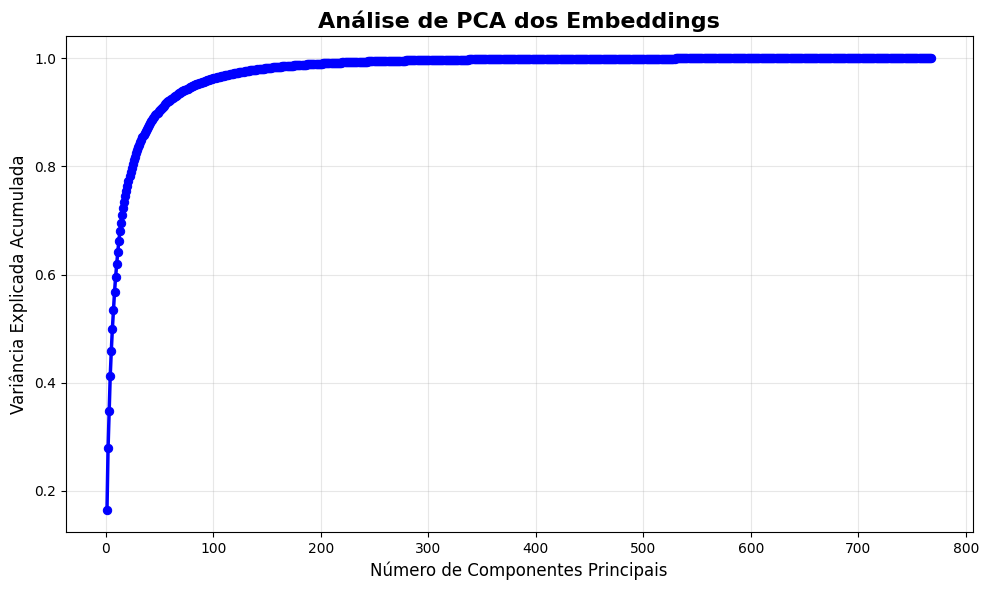

In [16]:
X = StandardScaler().fit_transform(embedding_df)
y = df_balanced['pago'].astype(int).values

test_pca = PCA(random_state=random_state)
X_pca = test_pca.fit_transform(X)

explained_variance = test_pca.explained_variance_ratio_.cumsum()

pca_df = pd.DataFrame({
    'Número de Componentes': range(1, len(explained_variance) + 1),
    'Variância Explicada Acumulada': explained_variance
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=pca_df, x='Número de Componentes', y='Variância Explicada Acumulada', marker='o',
             linewidth=2.5, markersize=6, color='blue', markeredgecolor='blue')

plt.xlabel('Número de Componentes Principais', fontsize=12)
plt.ylabel('Variância Explicada Acumulada', fontsize=12)
plt.title('Análise de PCA dos Embeddings', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
for exp_var in np.arange(0.95, 0.991, 0.01):
    pca_tmp = PCA(n_components=exp_var, random_state=random_state)
    pca_tmp.fit(X)
    print(f'Explicabilidade: {exp_var:.2f} -> Número de componentes: {pca_tmp.n_components_}')

Explicabilidade: 0.95 -> Número de componentes: 82
Explicabilidade: 0.96 -> Número de componentes: 96
Explicabilidade: 0.97 -> Número de componentes: 114
Explicabilidade: 0.98 -> Número de componentes: 143
Explicabilidade: 0.99 -> Número de componentes: 197


In [18]:
# PCA com 96% de explicabilidade
pca = PCA(n_components=pca_explainability, random_state=random_state)
embeddings_reduced = pca.fit_transform(embedding_df)

In [19]:
embeddings_reduced_df = pd.DataFrame(
    embeddings_reduced,
    columns=[f'component_{i}' for i in range(embeddings_reduced.shape[1])]
)
print_header("EMBEDDINGS REDUZIDOS", colors.text_cyan)
colorfull_print(f"Shape do DataFrame dos embeddings: {embeddings_reduced_df.shape}", colors.text_green)
embeddings_reduced_df.head()

EMBEDDINGS REDUZIDOS
Shape do DataFrame dos embeddings: (10000, 88)


,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,...,component_78,component_79,component_80,component_81,component_82,component_83,component_84,component_85,component_86,component_87
0,-0.166322,-1.049786,-1.590499,0.692251,0.246841,0.099668,0.422550,-0.239940,0.387366,-0.575724,...,-0.037149,-0.257089,0.048475,-0.200089,0.023332,0.091945,-0.123802,0.046104,-0.092179,-0.218182
1,5.885479,-0.242280,0.402036,-0.457136,0.059799,-0.056390,-0.160001,-0.105788,0.039564,-0.344299,...,0.007691,0.001337,-0.016246,-0.002871,-0.003349,0.015766,-0.029449,0.019828,0.023472,0.010108
2,5.885479,-0.242280,0.402036,-0.457136,0.059799,-0.056390,-0.160001,-0.105788,0.039564,-0.344299,...,0.007691,0.001337,-0.016246,-0.002871,-0.003349,0.015766,-0.029449,0.019828,0.023472,0.010108
3,0.254084,0.154220,-0.580684,2.563307,0.115287,-3.050545,0.684978,1.479045,0.104075,0.079908,...,0.034759,0.086959,0.005652,-0.033824,0.077839,0.097109,-0.068563,-0.088488,0.031436,0.020289
4,-0.040694,0.661086,0.996161,1.717267,-0.429104,-0.072237,0.542560,-0.662425,-0.853926,0.694198,...,0.170140,0.094343,0.021729,-0.245303,-0.217382,-0.085100,-0.121650,-0.008460,-0.448800,-0.332253


In [20]:
# Adicionando embeddings ao DataFrame balanceado
df_balanced_with_embeddings = pd.concat([
    df_balanced.reset_index(drop=True), 
    embeddings_reduced_df
], axis=1)

print_header("DATASET COM EMBEDDINGS", colors.text_cyan)
colorfull_print(f"Dimensões: {df_balanced_with_embeddings.shape[0]} linhas x {df_balanced_with_embeddings.shape[1]} colunas", colors.text_yellow)

df_balanced_with_embeddings.head()

DATASET COM EMBEDDINGS
Dimensões: 10000 linhas x 97 colunas


,codigo_item,codigo_glosa,valor_glosa,justificativa,valor_cobrado,quantidade_item,pago,convenio,prestador,component_0,...,component_78,component_79,component_80,component_81,component_82,component_83,component_84,component_85,component_86,component_87
0,70139164,2001,104.51,cobrança de material correto conforme contrato...,104.51,1,True,Bradesco,HOSPITALIS,-0.166322,...,-0.037149,-0.257089,0.048475,-0.200089,0.023332,0.091945,-0.123802,0.046104,-0.092179,-0.218182
1,20103212,1705,0.01,COBRANCA E VALOR CONFORME TABELA PROPRIA DE PR...,73.32,6,True,Bradesco,HOSPITALIS,5.885479,...,0.007691,0.001337,-0.016246,-0.002871,-0.003349,0.015766,-0.029449,0.019828,0.023472,0.010108
2,40301583,1705,0.67,COBRANCA E VALOR CONFORME TABELA PROPRIA DE PR...,9.30,1,False,Bradesco,HOSPITALIS,5.885479,...,0.007691,0.001337,-0.016246,-0.002871,-0.003349,0.015766,-0.029449,0.019828,0.023472,0.010108
3,90404823,1705,1.55,Medicamentos Brasindice Preço Máximo ao Consum...,21.70,1,False,Bradesco,HOSPITALIS,0.254084,...,0.034759,0.086959,0.005652,-0.033824,0.077839,0.097109,-0.068563,-0.088488,0.031436,0.020289
4,20201117,1705,49.99,"Considerar cód 20101040, CBHPM 4 edição com in...",91.65,1,True,UnimedCNU,BP,-0.040694,...,0.170140,0.094343,0.021729,-0.245303,-0.217382,-0.085100,-0.121650,-0.008460,-0.448800,-0.332253


In [21]:
# Separando features e target (agora com embeddings)
X_with_embeddings = df_balanced_with_embeddings.drop(columns=['pago', 'justificativa'])
y_with_embeddings = df_balanced_with_embeddings['pago']

colorfull_print(f"\nFeatures com embeddings: {X_with_embeddings.shape}", colors.text_green)
colorfull_print(f"Target: {y_with_embeddings.shape}", colors.text_green)


Features com embeddings: (10000, 95)
Target: (10000,)


# Encoders e pré-processamento

In [22]:
'''
    Tendo em vista que codigo_item e codigo_glosa possuem alta cardinalidade, vamos utilizar target encoding
    para essas features, já convenio e prestador vamos utilizar one hot encoding devido à baixa cardinalidade
'''

one_hot_cols = ['convenio', 'prestador']
target_encode_cols = ['codigo_item', 'codigo_glosa']
embedding_cols = [col for col in X_with_embeddings.columns if col.startswith('component_')]
numeric_cols = ['valor_cobrado', 'valor_glosa', 'quantidade_item']

# Transformações nos dados
transformer = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("onehot", OneHotEncoder(handle_unknown='ignore'), one_hot_cols),
    ("embeddings", 'passthrough', embedding_cols),
    ("target_encode", TargetEncoder(), target_encode_cols)
])



In [23]:

# Codificação dos labels para que f1_score consiga interpretar
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_with_embeddings)

# Métodos de Scoring
scoring = {
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
    'accuracy': "accuracy",
    'roc_auc': "roc_auc"
    
}
#definição kfold
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

# Modelos a serem testados
classifiers = {
    "Random Forest": Pipeline([
        ('preprocessing', transformer),
        ('classifier', RandomForestClassifier(random_state=random_state))
    ]),
    
    "MLP": Pipeline([
        ('preprocessing', transformer),
        ('classifier', MLPClassifier(random_state=random_state, max_iter=300))
    ]),
    
    "XGBoost": Pipeline([
        ('preprocessing', transformer),
        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state))
    ]),
    
    "CatBoost": Pipeline([
        ('preprocessing', transformer),
        ('classifier', CatBoostClassifier(random_state=random_state, verbose=0))
    ]),
    
    "KNN": Pipeline([
        ('preprocessing', transformer),
        ('classifier', KNeighborsClassifier())
    ])  
}


# Tuning

In [24]:
#Hiperparametros para tuning
grid_params = {
    "Random Forest": {
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [None, 15],
        'classifier__min_samples_split': [2, 5],
    },

    "MLP": {
        'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'classifier__activation': ['relu', 'tanh'],
        'classifier__learning_rate': ['constant', 'adaptive'],
    },

    "XGBoost": {
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [3, 6, 10],
        'classifier__learning_rate': [0.05, 0.1],
    },

    "CatBoost": {
        'classifier__iterations': [300, 500],
        'classifier__depth': [6, 8, 10],
        'classifier__learning_rate': [0.05, 0.1],
    },

    "KNN": {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__metric': ['euclidean', 'manhattan']
    }
}


tuned_models = {
    classifier: GridSearchCV(classifiers[classifier], param_grid=grid_params[classifier], cv=inner_cv, scoring="accuracy", n_jobs=-1)
    for classifier in classifiers
}


In [25]:
#define se vai usar os modelos tunados ou os padrões
if tuning:
    models = tuned_models
else:
    models = classifiers

# Avaliação dos modelos

In [26]:
scores = {}
for scorer in scoring:
    colorfull_print(f"\nCalculando scores com {scorer}...", colors.text_yellow)
    scores[scorer] = pd.DataFrame({
        model: cross_val_score(models[model], X_with_embeddings, y_with_embeddings, cv=outer_cv, scoring=scorer)
        for model in models
    })


Calculando scores com f1_macro...

Calculando scores com accuracy...

Calculando scores com roc_auc...


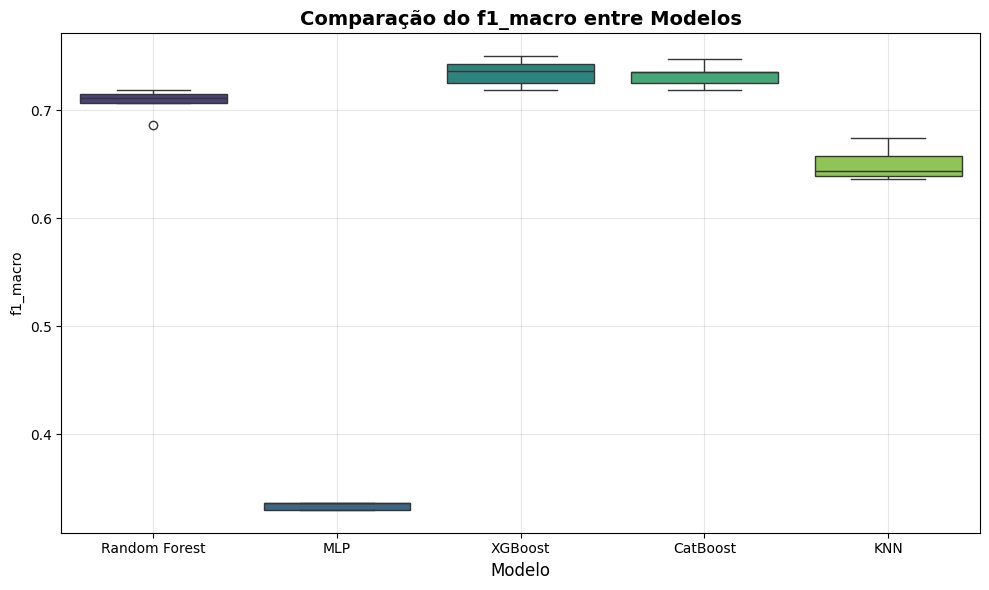

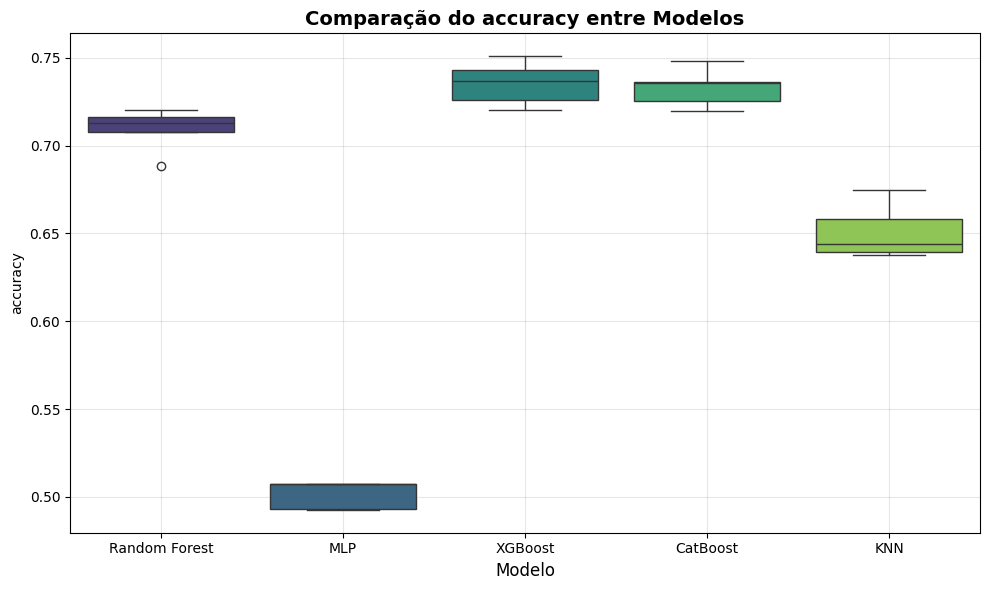

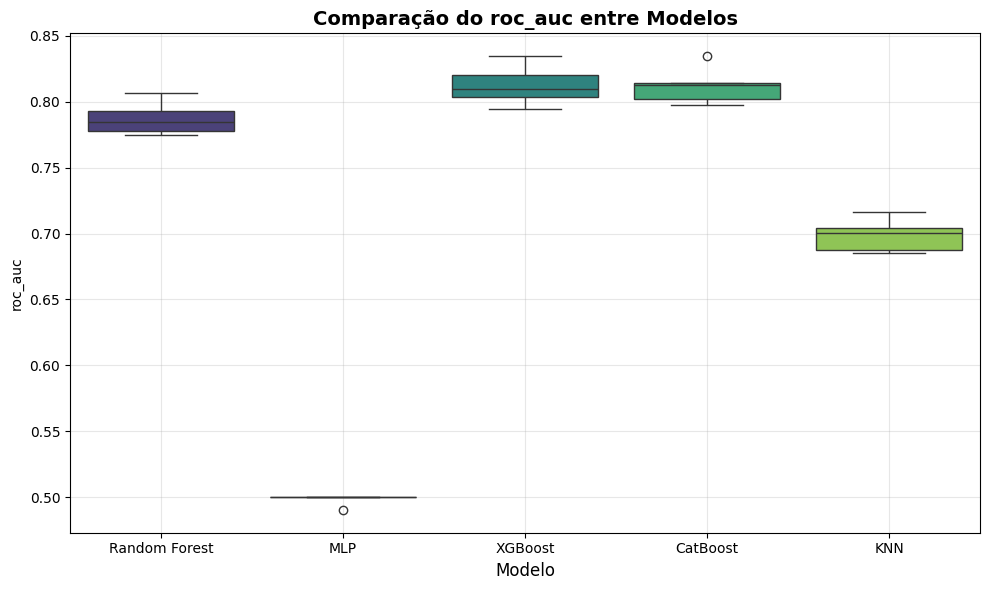

MÉDIA E DESVIO PADRÃO DO F1_MACRO
      Random Forest       MLP   XGBoost  CatBoost       KNN
mean       0.707646  0.334028  0.734864  0.732472  0.650377
std        0.012708  0.003591  0.012632  0.011016  0.015614
MÉDIA E DESVIO PADRÃO DO ACCURACY
      Random Forest       MLP   XGBoost  CatBoost       KNN
mean       0.709200  0.501600  0.735300   0.73290  0.650800
std        0.012518  0.008081  0.012528   0.01094  0.015719
MÉDIA E DESVIO PADRÃO DO ROC_AUC
      Random Forest       MLP   XGBoost  CatBoost       KNN
mean       0.787294  0.498245  0.812335  0.812247  0.698711
std        0.012764  0.004481  0.015603  0.014500  0.012630


In [27]:
# Reformatando o DataFrame
for scorer in scores:
    score_melted = scores[scorer].melt(var_name='Modelo', value_name=scorer)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Modelo', y=scorer, hue='Modelo', data=score_melted, palette='viridis', legend=False)
    plt.title(f'Comparação do {scorer} entre Modelos', fontsize=14, fontweight='bold')
    plt.xlabel('Modelo', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Médias e desvio padrão
for scorer in scores:
    print_header(f"MÉDIA E DESVIO PADRÃO DO {scorer.upper()}", colors.text_cyan)
    colorfull_print(scores[scorer].agg(['mean', 'std']), colors.text_yellow)


In [28]:
# Predições de cada modelo
predictions = {
    model: cross_val_predict(models[model], X_with_embeddings, y_encoded, cv=outer_cv, n_jobs=-1)
    for model in models
}


# Matrizes de confusão

confusion_matrixes = {
    model: confusion_matrix(y_encoded, predictions[model])
    for model in models
}


# Nomes das classes
class_names = label_encoder.classes_


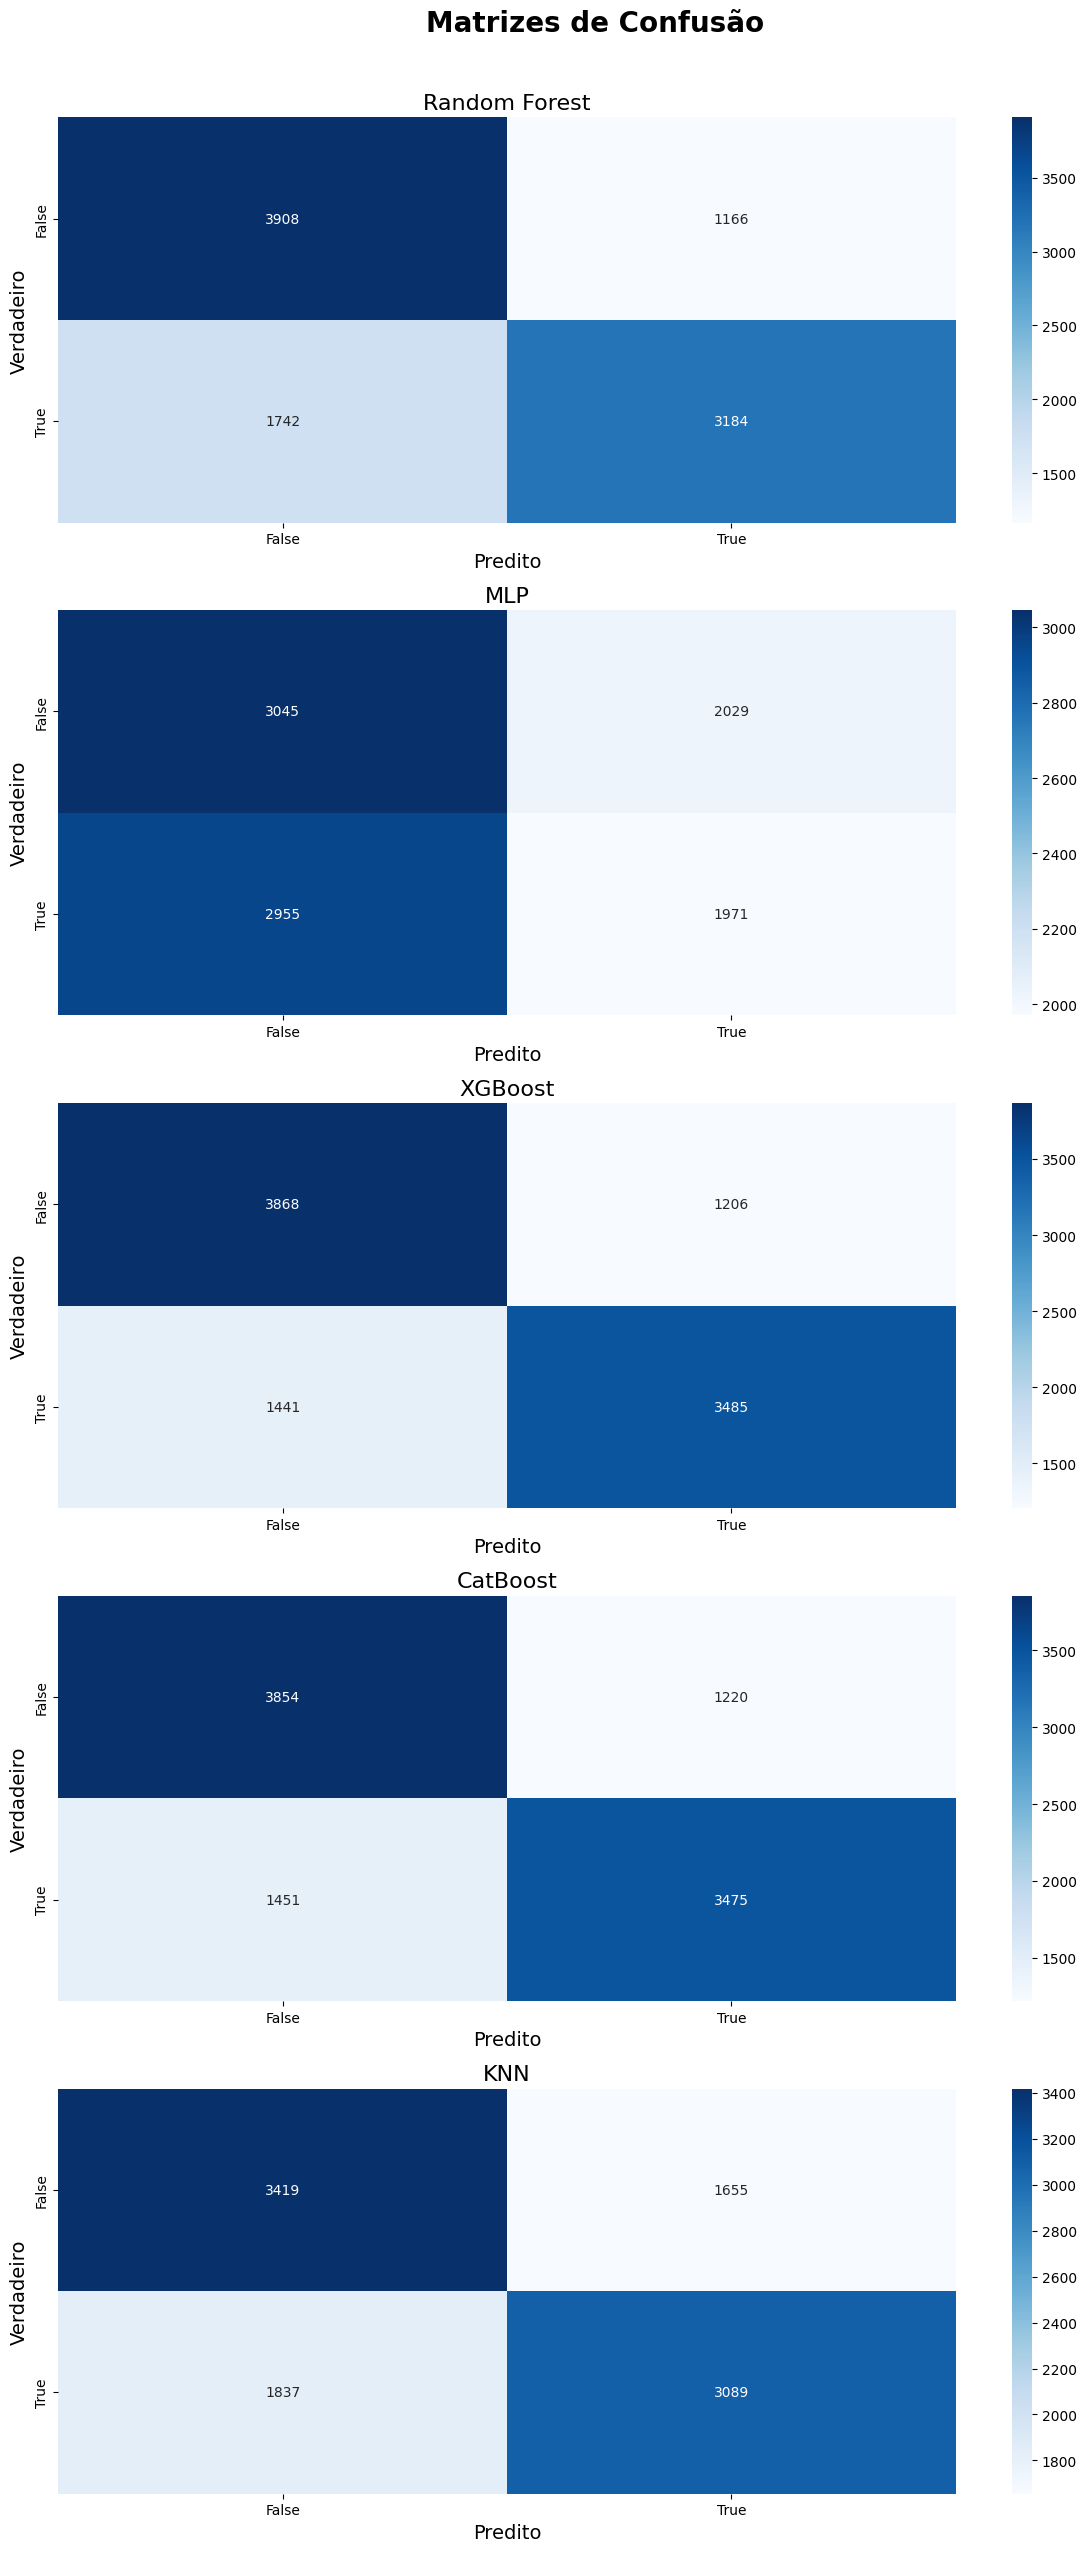

In [29]:

''' 
    Plotando as matrizes de confusão
'''
fig, axes = plt.subplots(len(models), 1, figsize=(12, 26))
fig.suptitle('Matrizes de Confusão', fontsize=20, fontweight='bold')

for index, (model) in enumerate(models):
    
    sns.heatmap(confusion_matrixes[model], annot=True, fmt='d', cmap='Blues', ax=axes[index], 
                xticklabels=class_names, yticklabels=class_names)
    axes[index].set_title(model, fontsize=16)
    axes[index].set_xlabel('Predito', fontsize=14)
    axes[index].set_ylabel('Verdadeiro', fontsize=14)


plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
